## Run basic `scanpy` QC and doublet detection with `scrublet` for ACM murine cardiac leucocytes data set 6 month post MCMV infection

### Pkp2 Experiment 2 Library 1 (Index A3-E9)


- **Developed by**: Carlos Talavera-López PhD
- **Modified by**: Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation**: 230828
- **Date of modification**: 240216

#### Mouse information

Index   | Ear punch     | Genotype  | Infection
:---:   | :---:         | :---:     | :---:
1       | 32            | het ko    | PBS
2       | 65            | het ko    | PBS
3       | 39            | Ctr       | MCMV
4       | 40            | Ctr       | MCMV
5       | 43            | Ctr       | MCMV
6       | 67            | Ctr       | PBS
7       | 31            | Ctr       | PBS
8       | 56            | het ko    | MCMV
9       | 58            | het ko    | MCMV
10      | 26            | het ko    | MCMV

### Load required modules

In [33]:
import anndata
import logging
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sb
import scrublet as scr
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rcParams

In [34]:
%matplotlib inline
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
annoy               NA
asttokens           NA
attr                23.2.0
attrs               23.2.0
cattr               NA
cattrs              NA
certifi             2024.02.02
charset_normalizer  3.3.2
colorama            0.4.6
comm                0.2.1
cycler              0.12.1
cython_runtime      NA
dateutil            2.8.2
debugpy             1.8.1
decorator           5.1.1
executing           2.0.1
future              0.18.3
h5py                3.10.0
idna                3.6
igraph              0.11.4
ipykernel           6.29.2
ipywidgets          8.1.2
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lazy_loader         NA
leidenalg           0.10.2
llvmlite            0.42.0
matplotlib          3.8.2
matplotlib_inline   0.1.6
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.0
numpy               1.26.4
packaging           23.2
pandas         

### Read individual `anndata` objects and predict doublets per sample

In [35]:
# Create an AnnData object
adata = sc.read_10x_mtx(
    '/home/guest1/data/ACM_cardiac_leuco/Pkp2/E9_Pkp2_Exp2_Library1/filtered_feature_bc_matrix/',                                                # the directory with the `.mtx` file
    var_names='gene_symbols',                                                                                                               # use gene symbols for the variable names (variables-axis index)
    cache=True)                                                                                                                             # write a cache file for faster subsequent reading

adata.var_names_make_unique()                                                                                                               # makes the index unique by adding a number string to each duplicated index element
                                                                                                                                            # This is not needed if 'var_names='gene_ids' would have been used before
sample_id = 'A'
adata.obs["sample"] = sample_id
adata.obs

... reading from cache file cache/home-guest1-data-ACM_cardiac_leuco-Pkp2-E9_Pkp2_Exp2_Library1-filtered_feature_bc_matrix-matrix.h5ad


/home/guest1/apps/mamba/envs/Scanpy/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


,sample
AAACCCACAAATCGGG-1,A
AAACCCACACCCGTAG-1,A
AAACCCACAGTTCTAG-1,A
AAACCCAGTCGATTTG-1,A
AAACCCATCACTTGGA-1,A
...,...
TTTGTTGGTATAGGAT-1,A
TTTGTTGGTGGCTAGA-1,A
TTTGTTGGTTTAGACC-1,A
TTTGTTGTCTCATGGA-1,A


In [36]:
adata

AnnData object with n_obs × n_vars = 11824 × 32285
    obs: 'sample'
    var: 'gene_ids', 'feature_types'

In [37]:
sc.pp.filter_cells(adata, min_genes = 200)
print(adata.n_obs, adata.n_vars)

filtered out 600 cells that have less than 200 genes expressed
11224 32285


##### Run `scrublet` to identify doublets 

`scrublet` can identify "neotypic" doublets (from cells with different gene expression patterns) in "simulated doublets". It cannot detect "embedded" doublets generated by two cells with similar gene expression.
To call doublets vs singlets, we must set a threshold doublet score at the minimum between the two modes of the simulated doublet histogram. If `scrublet` is unable to perform this steo properly, the threshold can be adjusted by scrub.call_doublets(threshold=0.25)



Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 16.5%
Elapsed time: 12.2 seconds


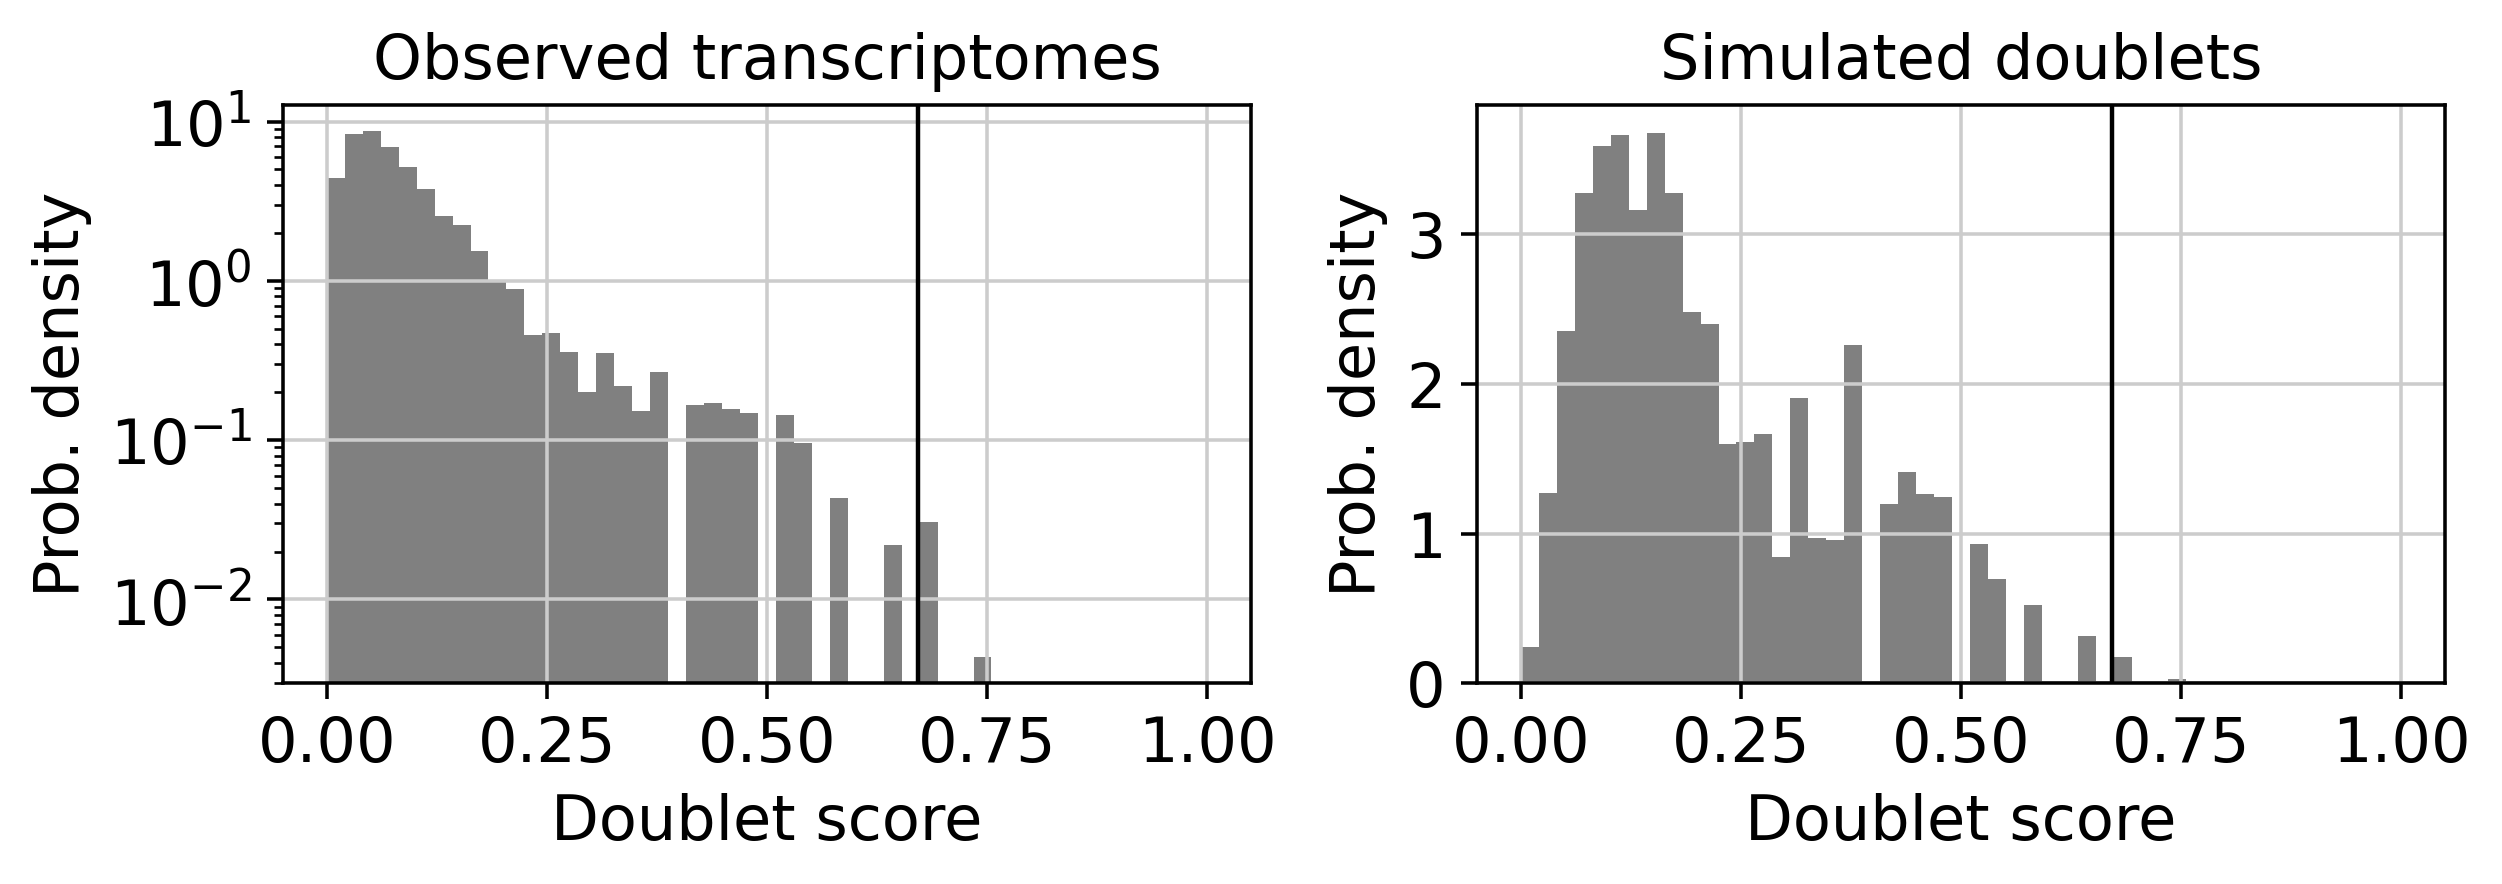

In [38]:
sample_names = adata.obs['sample'].unique()

for sample_name in sample_names:
    mask = adata.obs['sample'] == sample_name
    sample_adata = adata[mask].copy()

    scrub = scr.Scrublet(sample_adata.X)                                                                     #Initialize Scrublet object

    sample_adata.obs['doublet_scores'], sample_adata.obs['predicted_doublets'] = scrub.scrub_doublets()     #Run the default pipline including Doublet simulation, normalization, gene filtering, rescaling, PCA, Doublet score calcualtion, doublet score calculation and doulet calling

    
    adata.obs.loc[mask, 'doublet_scores'] = sample_adata.obs['doublet_scores']
    adata.obs.loc[mask, 'predicted_doublets'] = sample_adata.obs['predicted_doublets']

    scrub.plot_histogram()

    plt.show()

In [39]:
adata

AnnData object with n_obs × n_vars = 11224 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

In [40]:
sample_object = adata.copy()
sample_object

AnnData object with n_obs × n_vars = 11224 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'predicted_doublets'
    var: 'gene_ids', 'feature_types'

### Compute QC stats

In [41]:
sample_object.shape

(11224, 32285)

In [42]:
sample_object.var['mt'] = sample_object.var_names.str.startswith('mt-') 
sample_object.var['ribo'] = sample_object.var_names.str.startswith(("Rps","Rpl"))
sample_object.var

,gene_ids,feature_types,mt,ribo
Xkr4,ENSMUSG00000051951,Gene Expression,False,False
Gm1992,ENSMUSG00000089699,Gene Expression,False,False
Gm19938,ENSMUSG00000102331,Gene Expression,False,False
Gm37381,ENSMUSG00000102343,Gene Expression,False,False
Rp1,ENSMUSG00000025900,Gene Expression,False,False
...,...,...,...,...
AC124606.1,ENSMUSG00000095523,Gene Expression,False,False
AC133095.2,ENSMUSG00000095475,Gene Expression,False,False
AC133095.1,ENSMUSG00000094855,Gene Expression,False,False
AC234645.1,ENSMUSG00000095019,Gene Expression,False,False


In [43]:
sc.pp.calculate_qc_metrics(sample_object, qc_vars = ['mt','ribo'], percent_top = None, log1p = False, inplace = True)

sample_object

AnnData object with n_obs × n_vars = 11224 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [44]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
# add the total counts per cell as observations-annotation to adata

mito_genes = sample_object.var_names.str.startswith('mt-')
sample_object.obs['percent_mt'] = np.sum(
    sample_object[:, mito_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1)
sample_object.obs['n_counts'] = sample_object.X.sum(axis = 1)

sample_object

AnnData object with n_obs × n_vars = 11224 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Visualise QC covariates

In [45]:
sample_object.var_names 

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587',
       'Gm37323', 'Mrpl15', 'Lypla1',
       ...
       'Gm16367', 'AC163611.1', 'AC163611.2', 'AC140365.1', 'AC124606.2',
       'AC124606.1', 'AC133095.2', 'AC133095.1', 'AC234645.1', 'AC149090.1'],
      dtype='object', length=32285)

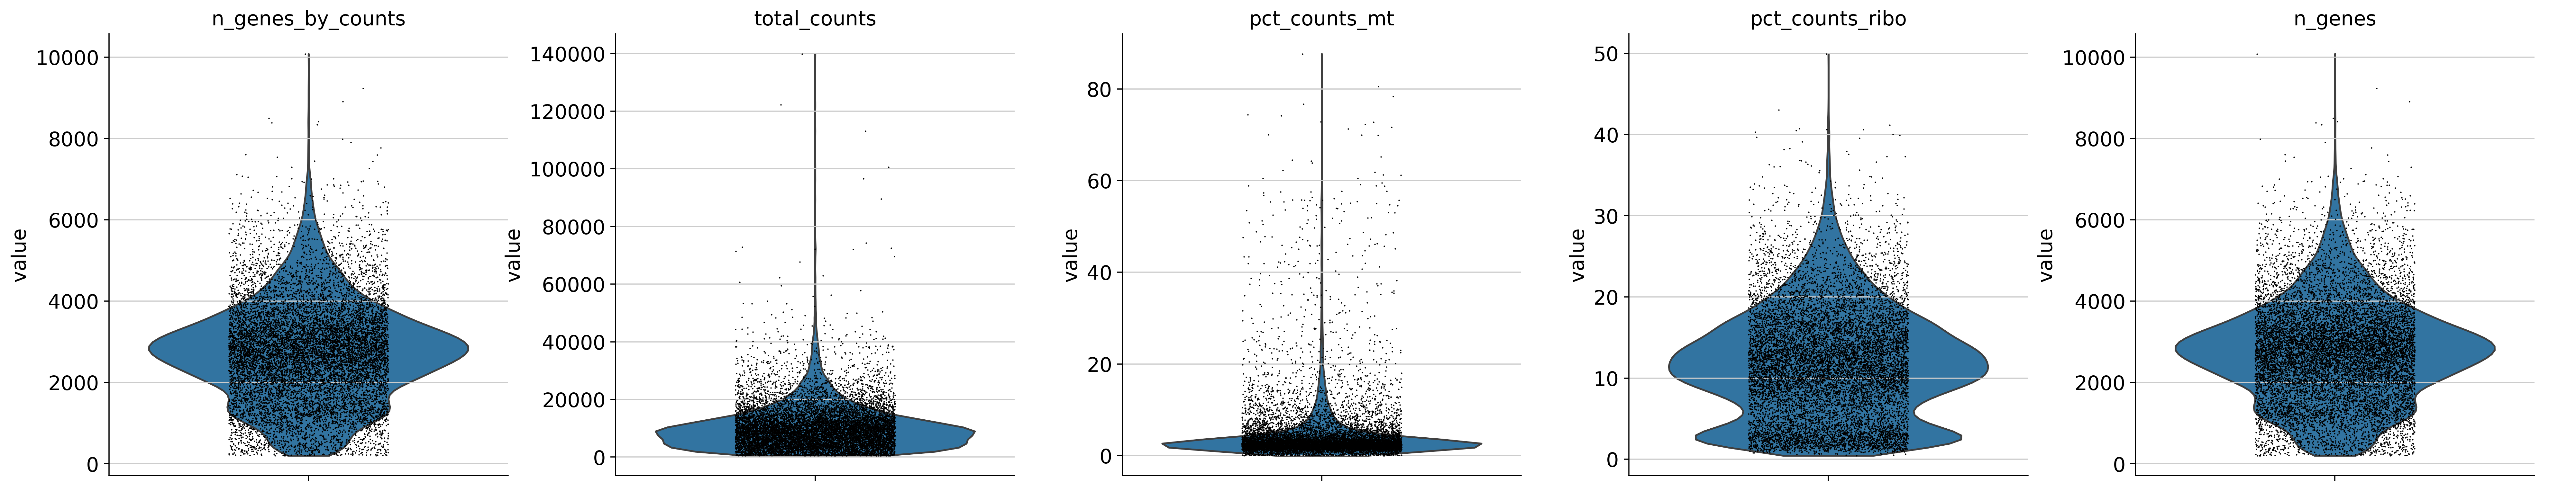

In [46]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'n_genes'],
             jitter = 0.2, rotation = 45, multi_panel= True)        #when having more than 1 sample add: groupby= 'sample'

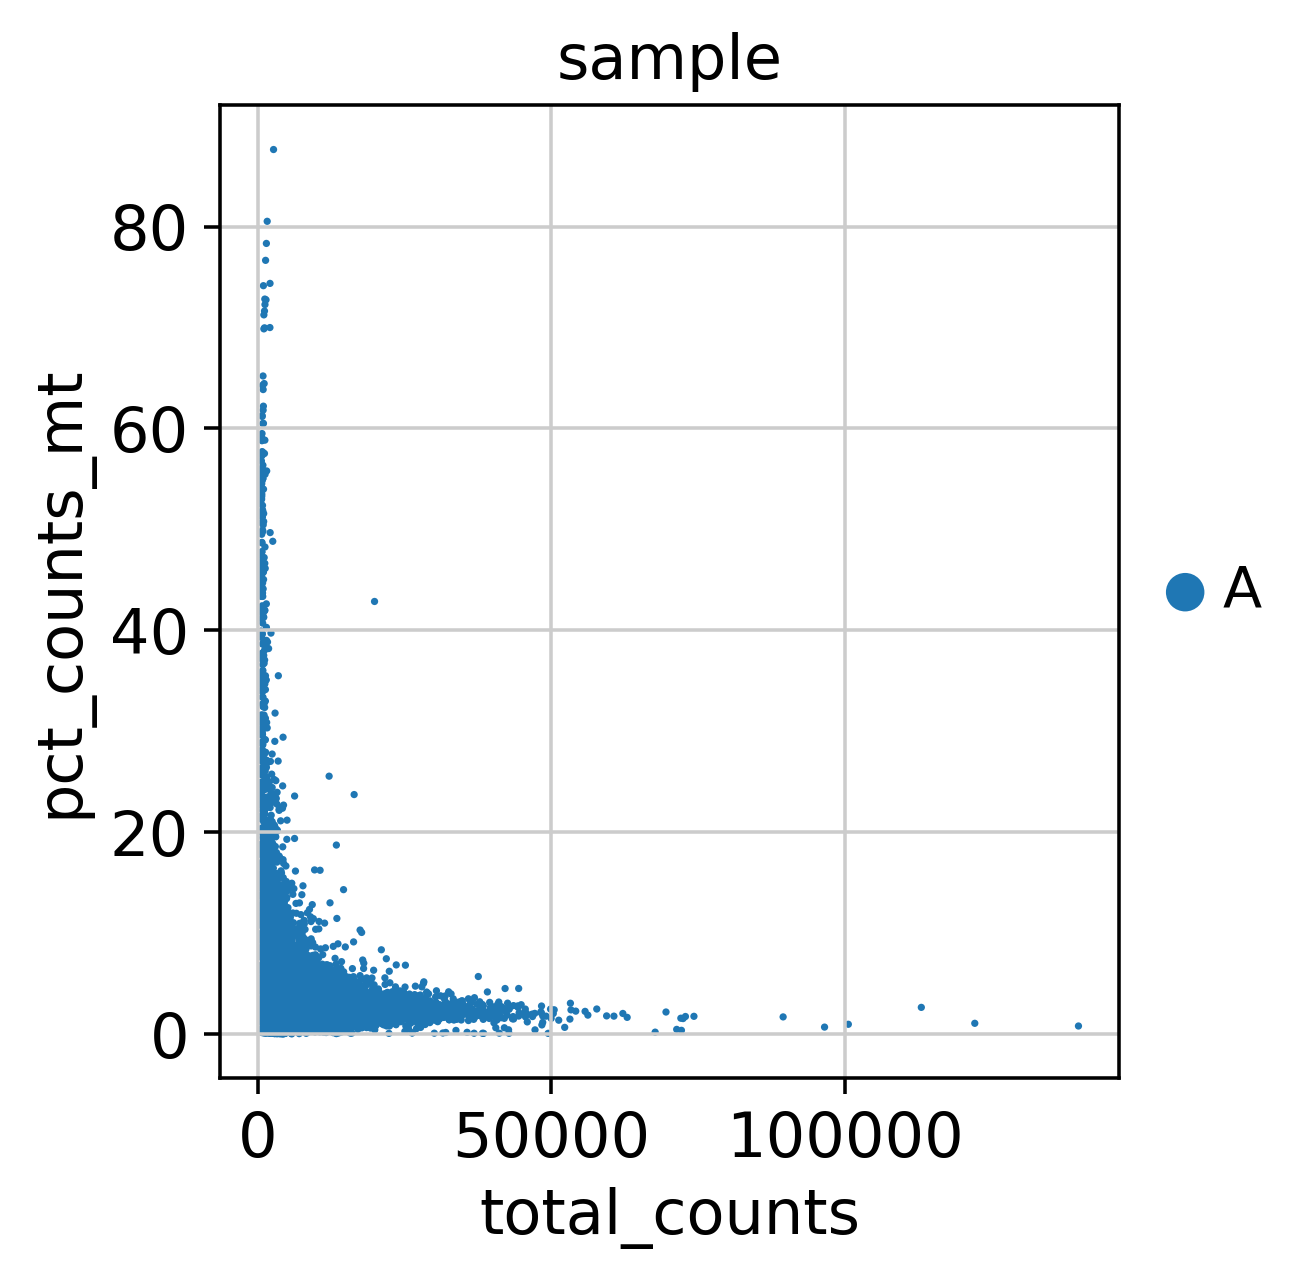

In [47]:
sc.pl.scatter(sample_object, x = 'total_counts', y = 'pct_counts_mt', color = "sample")

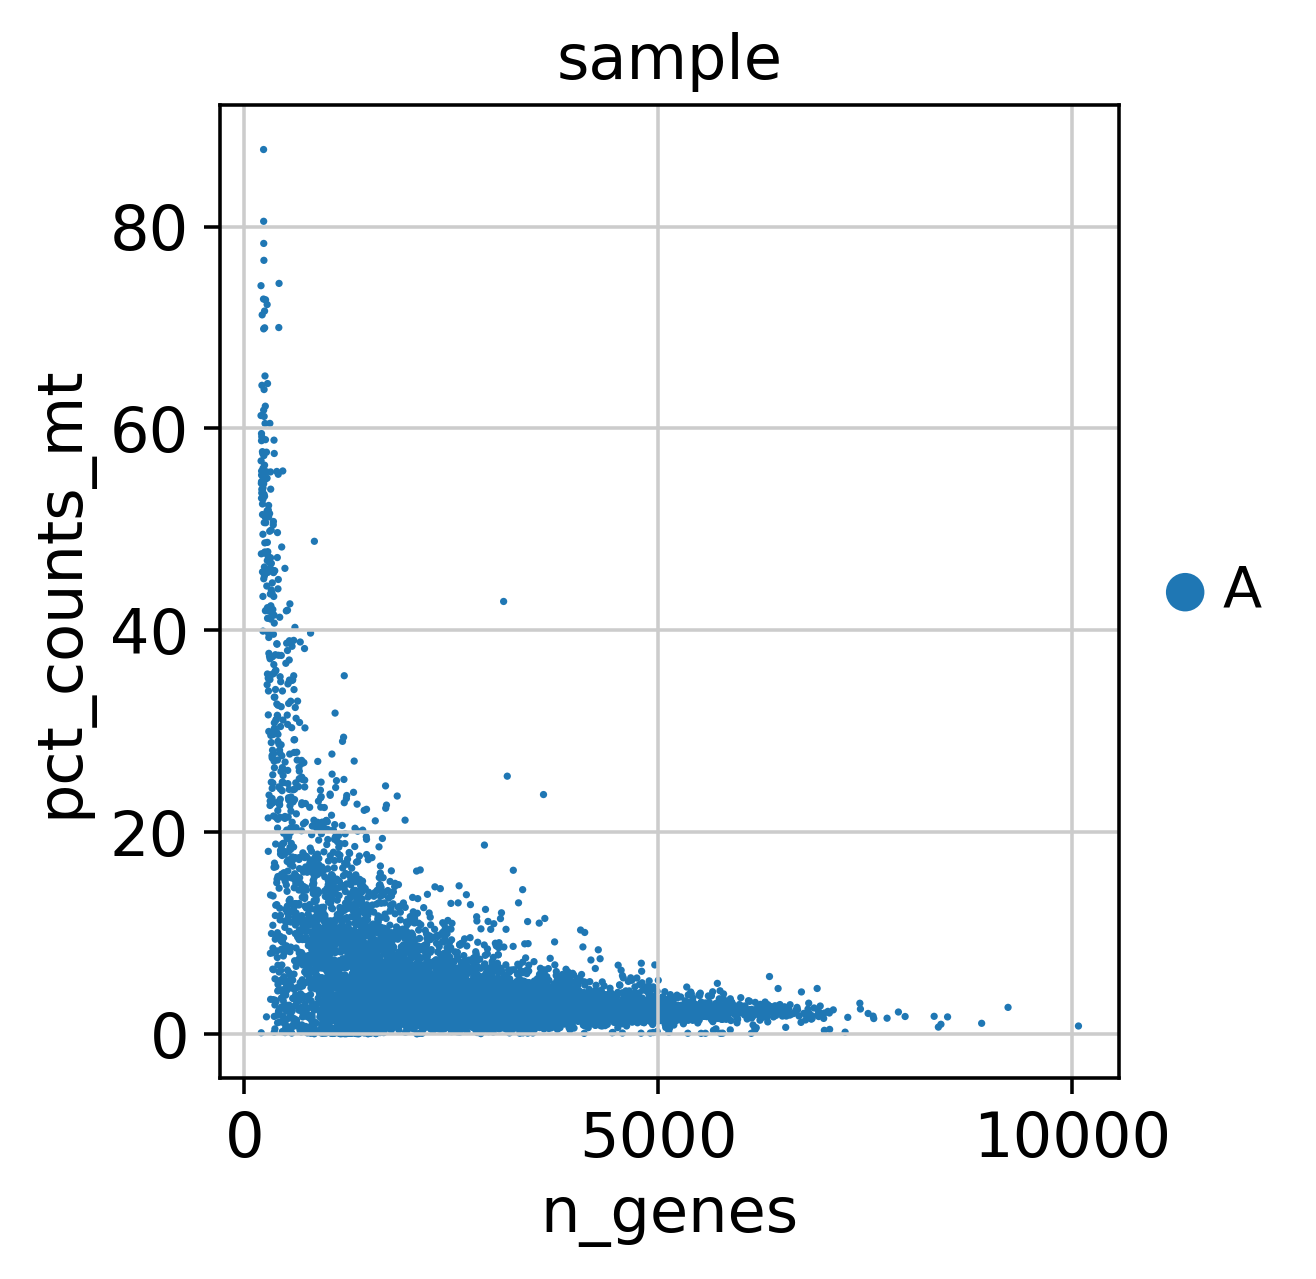

In [48]:
sc.pl.scatter(sample_object, x = 'n_genes', y = 'pct_counts_mt', color = "sample")

### Add sample sex covariate

In [49]:
annot = sc.queries.biomart_annotations(
        "mmusculus",
        ["ensembl_gene_id", "external_gene_name", "start_position", "end_position", "chromosome_name"],
    ).set_index("external_gene_name")

In [50]:
annot.head()

,ensembl_gene_id,start_position,end_position,chromosome_name
external_gene_name,,,,
mt-Tf,ENSMUSG00000064336,1,68,MT
mt-Rnr1,ENSMUSG00000064337,70,1024,MT
mt-Tv,ENSMUSG00000064338,1025,1093,MT
mt-Rnr2,ENSMUSG00000064339,1094,2675,MT
mt-Tl1,ENSMUSG00000064340,2676,2750,MT


In [51]:
chrY_genes = sample_object.var_names.intersection(annot.index[annot.chromosome_name == "Y"])
chrY_genes

Index(['Gm29089', 'Zfy1', 'Uba1y', 'Gm28588', 'Gm28587', 'Kdm5d', 'Eif2s3y',
       'Gm29650', 'Uty', 'Ddx3y',
       ...
       'Gm28672', 'Gm28670', 'Gm28673', 'Gm28674', 'Gm21996', 'Gm28930',
       'Gm29504', 'Gm20837', 'Gm28300', 'Gm28301'],
      dtype='object', length=719)

In [52]:
sample_object.obs['percent_chrY'] = np.sum(
    sample_object[:, chrY_genes].X, axis = 1) / np.sum(sample_object.X, axis = 1) * 100

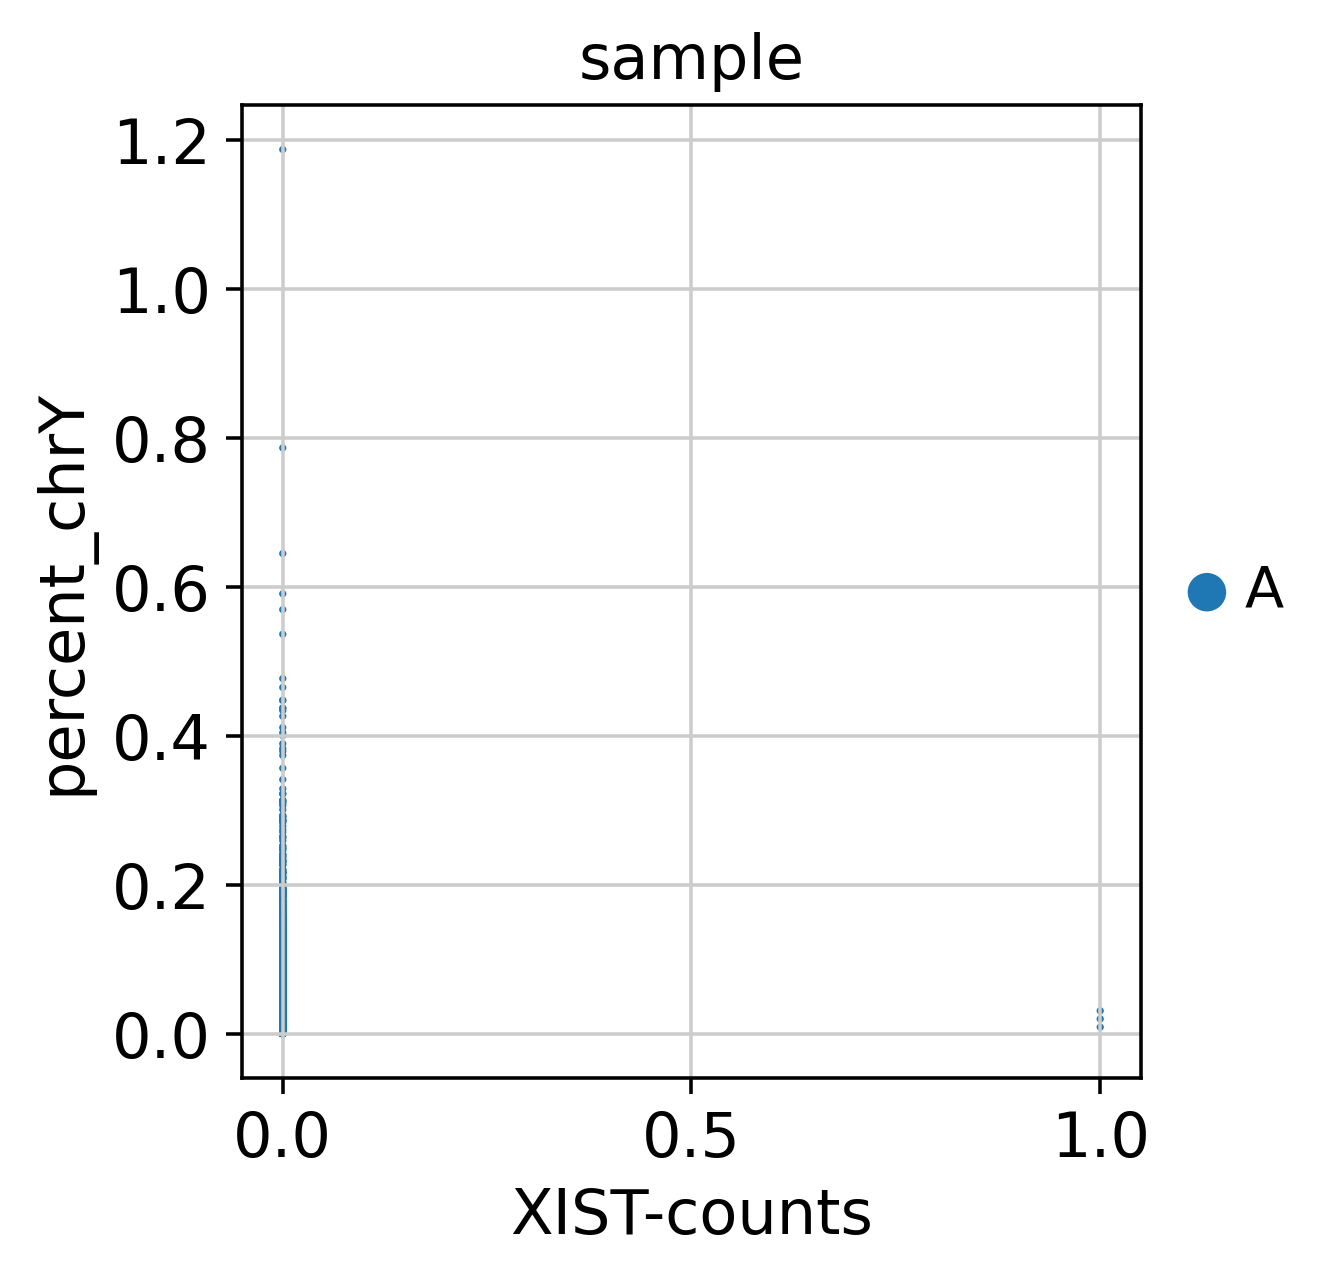

In [53]:
xist_counts = sample_object.X[:, sample_object.var_names.str.match('Xist')].toarray()
xist_counts_series = pd.Series(xist_counts.squeeze(), index = sample_object.obs_names, name = "XIST-counts")
sample_object.obs["XIST-counts"] = xist_counts_series

sc.pl.scatter(sample_object, x = 'XIST-counts', y = 'percent_chrY', color = "sample")

/home/guest1/apps/mamba/envs/Scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


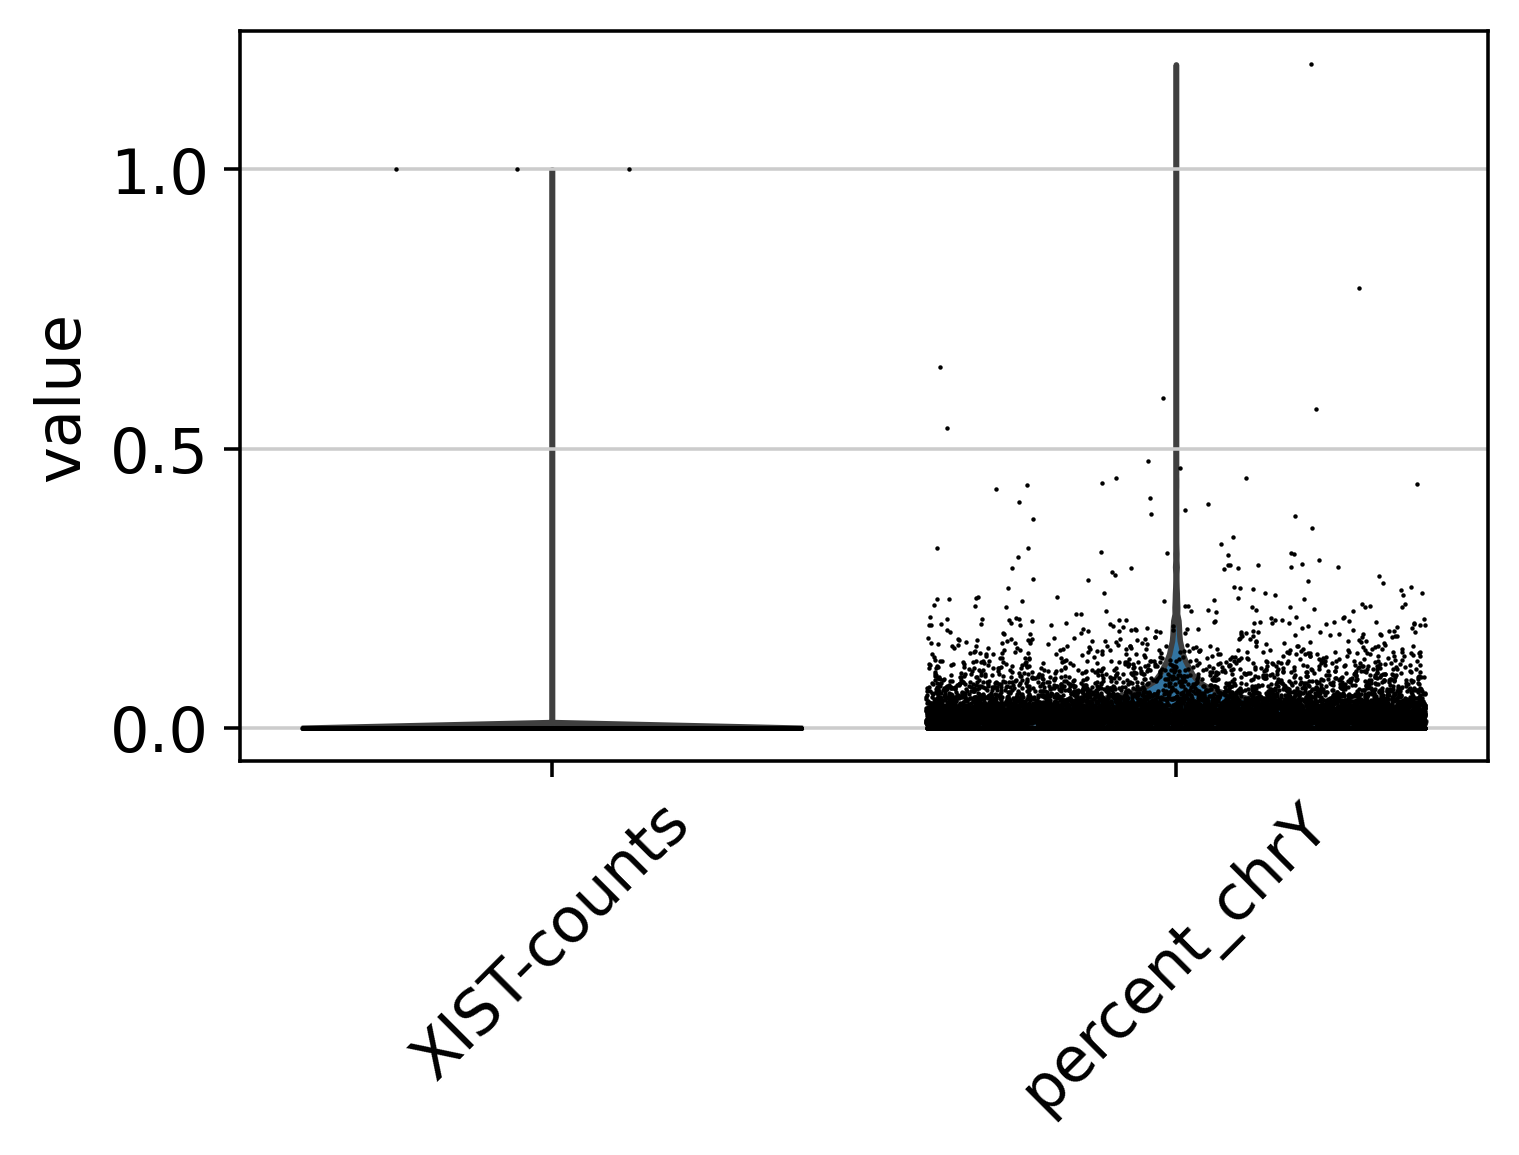

In [54]:
fig, ax = plt.subplots(figsize = (5,3))
sc.pl.violin(sample_object, ["XIST-counts", "percent_chrY"], jitter = 0.4, rotation = 45, ax=ax)   #when having more than 1 sample add: groupby= 'sample'

### Calculate cell cycle scores

In [55]:
!if [ ! -f /home/guest1/github/AG-Gerull_ACM/1-QC_training/data/regev_lab_cell_cycle_genes.txt ]; then curl -o ../data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

In [56]:
cell_cycle_genes = [x.strip() for x in open('/home/guest1/github/ACM_Mouse_Immune/data/regev_lab_cell_cycle_genes.txt')]
cell_cycle_genes = [gene.capitalize() for gene in cell_cycle_genes] #needed when analyzing mouse data
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in sample_object.var_names]
print(len(cell_cycle_genes))

97
94


- Create basic `anndata` for score calculation

In [57]:
adata_log = anndata.AnnData(X = sample_object.X,  var = sample_object.var, obs = sample_object.obs)
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Cst3', 'S100a8', 'S100a9', 'Cxcl2', 'Myl2', 'Actb', 'Igkc', 'Apoe', 'Ftl1', 'Hbb-bt', 'Hbb-bs', 'Lyz2', 'Hba-a1', 'Hba-a2', 'Ccl5', 'Ccl4', 'Ighg2c', 'Cma1', 'Mcpt4', 'Retnla', 'Gm26917', 'Gm42418', 'Cd74', 'Malat1', 'Fth1', 'Tmsb4x', 'mt-Nd1', 'mt-Nd2', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3', 'mt-Nd4', 'mt-Cytb']
    finished (0:00:00)


calculating cell cycle phase
computing score 'S_score'


    finished: added
    'S_score', score of gene set (adata.obs).
    385 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    473 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


/home/guest1/apps/mamba/envs/Scanpy/lib/python3.12/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


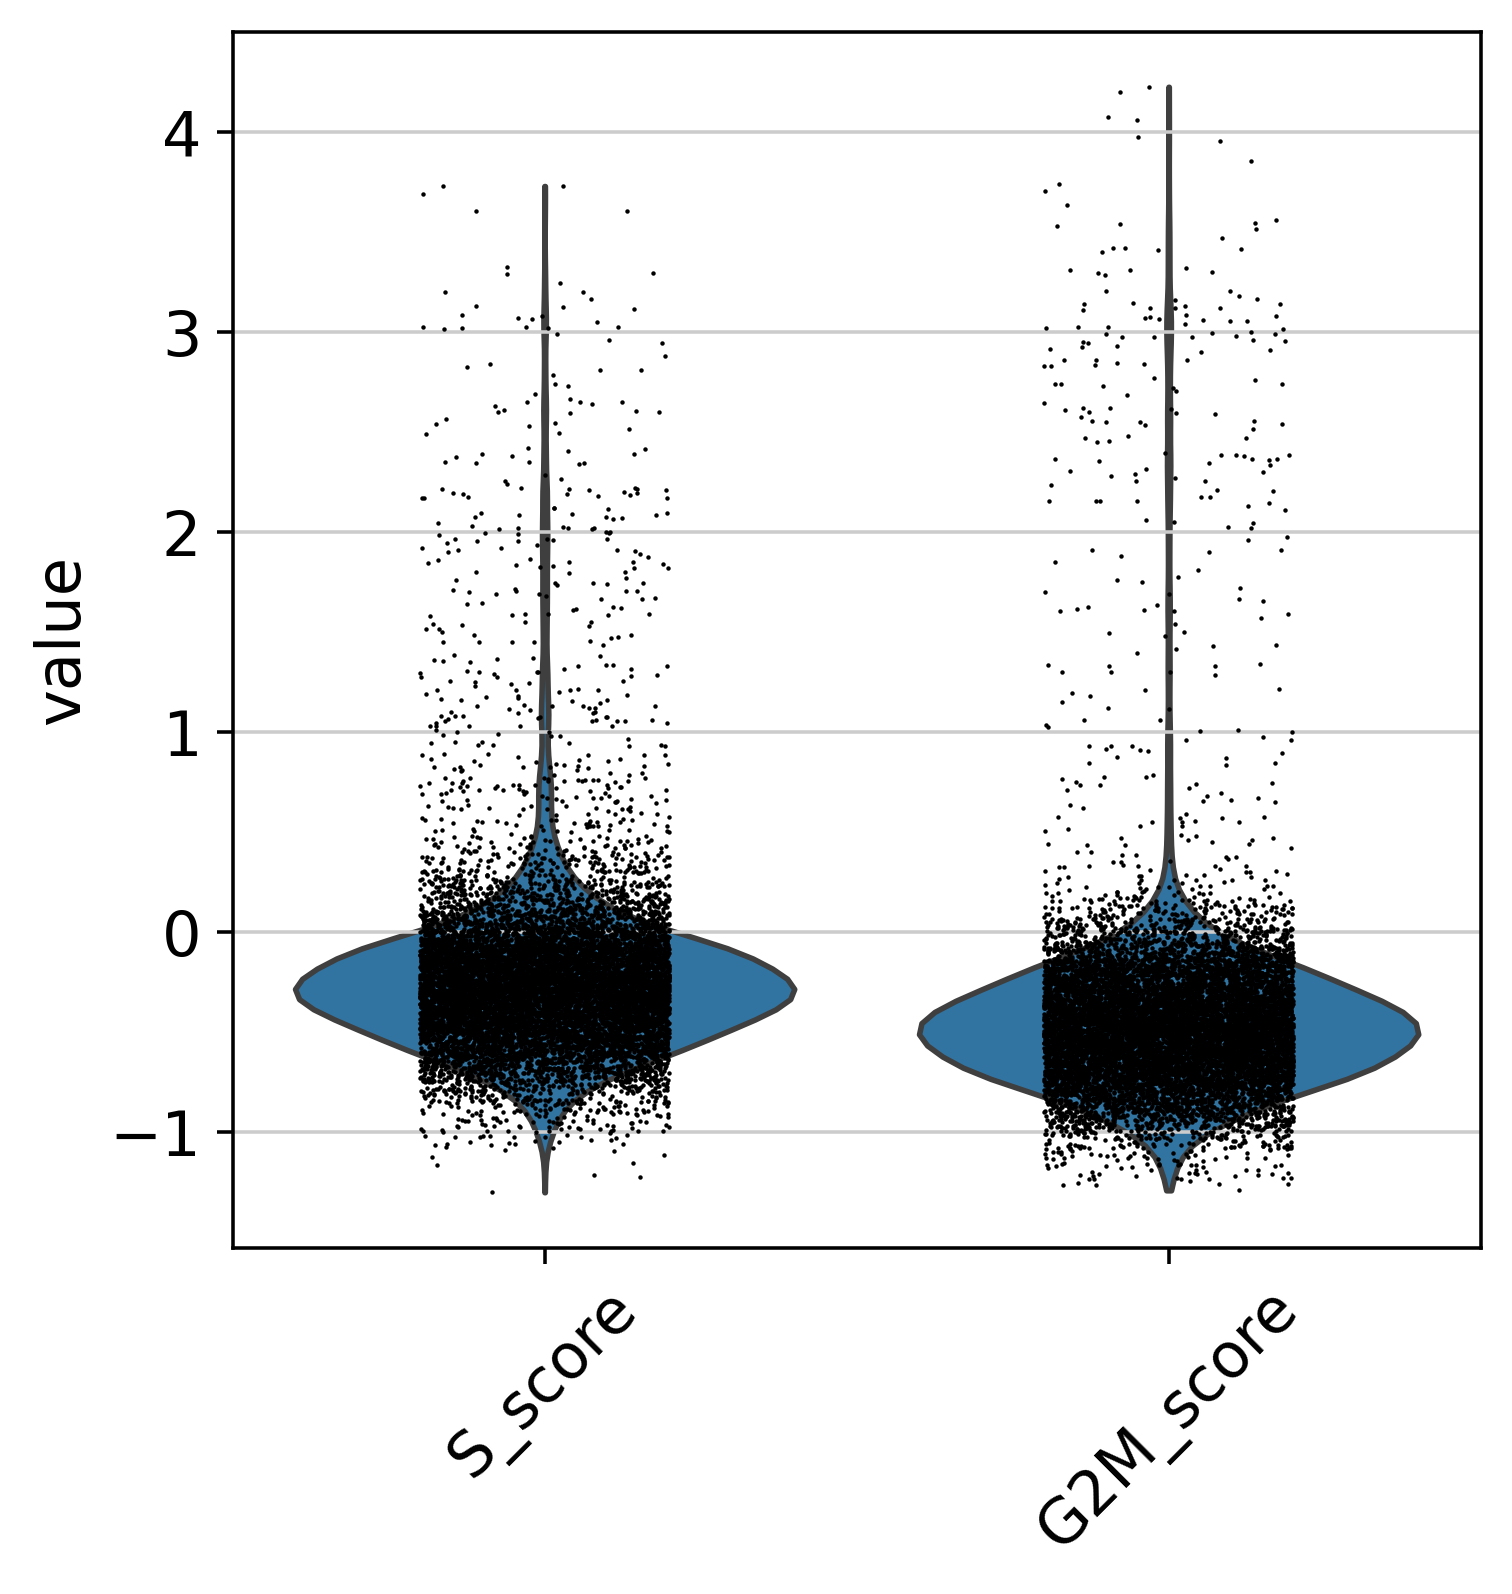

In [58]:
fig, ax = plt.subplots(figsize = (5,5))
sc.tl.score_genes_cell_cycle(adata_log, s_genes = s_genes, g2m_genes = g2m_genes)
sc.pl.violin(adata_log, ['S_score', 'G2M_score'],
             jitter = 0.2, rotation = 45, ax=ax)           #when having more than 1 sample add: groupby= 'sample'

In [59]:
sample_object.obs['S_score'] = adata_log.obs['S_score']
sample_object.obs['G2M_score'] = adata_log.obs['G2M_score']
sample_object

AnnData object with n_obs × n_vars = 11224 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'

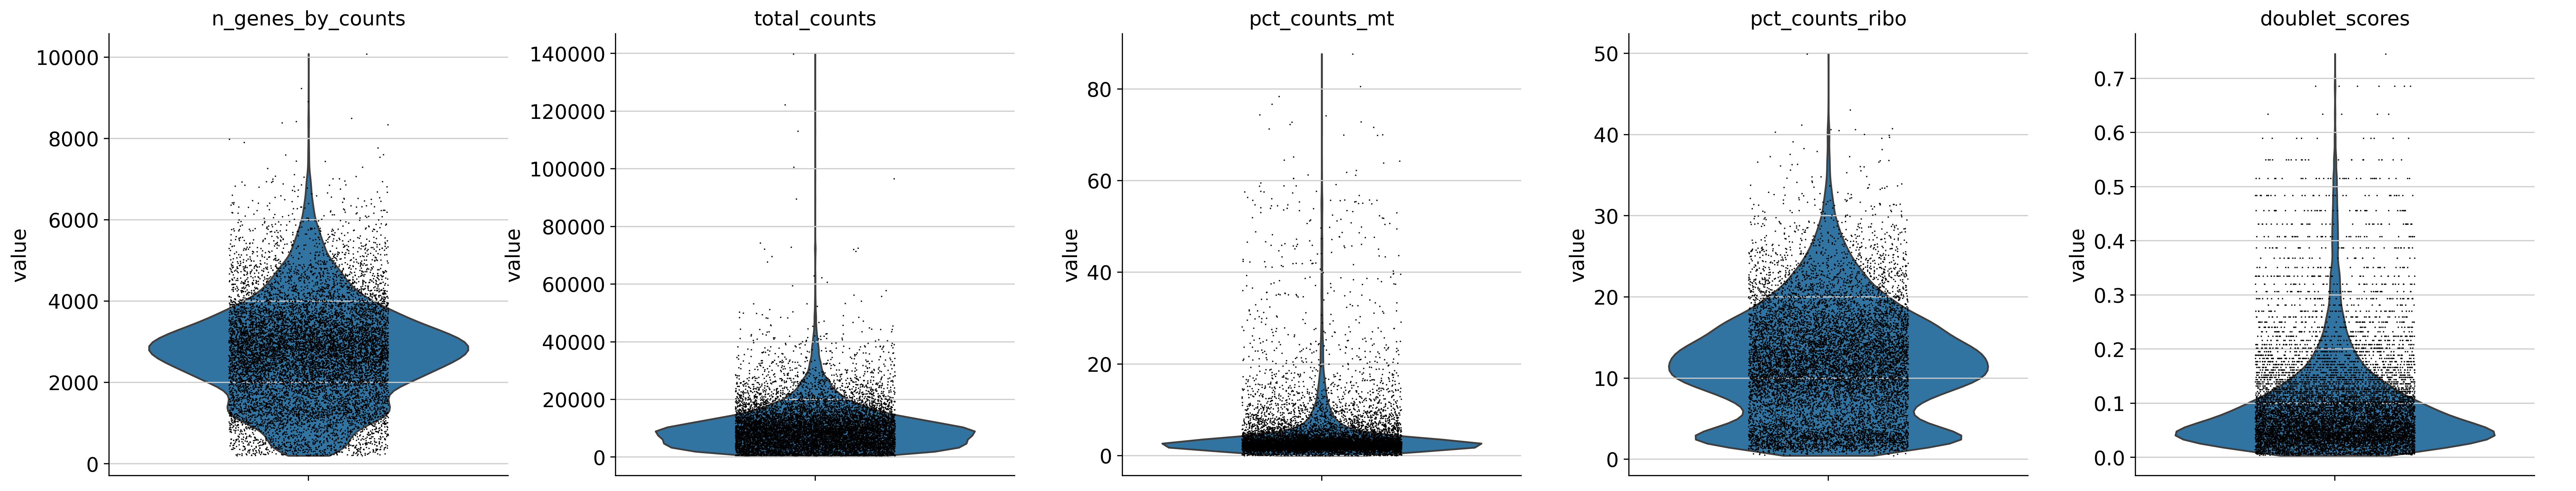

In [60]:
sc.pl.violin(sample_object, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo', 'doublet_scores'],
             jitter = 0.2, rotation = 45, multi_panel= True)           #when having more than 1 sample add: groupby= 'sample'

### Prepare counts for individual slots

In [61]:
sample_object.raw = sample_object.copy()
sample_object.layers['counts'] = sample_object.X.copy()
sample_object.layers["sqrt_norm"] = np.sqrt(
    sc.pp.normalize_total(sample_object, inplace = False)["X"]
)
sample_object

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 11224 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'predicted_doublets', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

In [62]:
del(sample_object.obs['predicted_doublets'])

## Perform QC Filtering based on diagnostic manifold notebook

In [63]:
# Perform QC-Filtering by slicing the AnnData object

sample_object = sample_object[sample_object.obs.n_counts < 40000, :]
sample_object = sample_object[sample_object.obs.doublet_scores < 0.29, :]

sample_object

View of AnnData object with n_obs × n_vars = 10671 × 32285
    obs: 'sample', 'n_genes', 'doublet_scores', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'n_counts', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'sample_colors'
    layers: 'counts', 'sqrt_norm'

### Export object

In [64]:
sample_object.write("/home/guest1/data/ACM_cardiac_leuco/Pkp2/E9_Pkp2_Exp2_Library1/processed/Pkp2_A3_QCed_ac240216.raw.h5ad")